In [1]:
!mkdir cifar10_cnn_pytorch
%cd cifar10_cnn_pytorch


/content/cifar10_cnn_pytorch


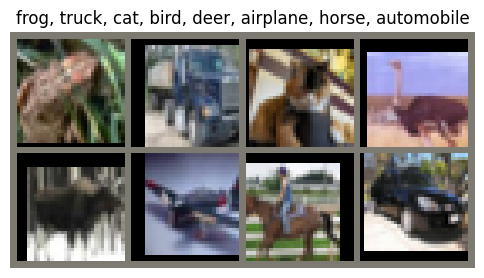

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Helper: unnormalize and show images
def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))  # C,H,W -> H,W,C

    # CIFAR-10 normalization values (same as in your transforms)
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2470, 0.2435, 0.2616])

    img = std * img + mean  # unnormalize
    img = np.clip(img, 0, 1)

    plt.figure(figsize=(6,6))
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Get one batch
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Make a grid of images (8 images)
grid_img = torchvision.utils.make_grid(images[:8], nrow=4)
label_names = [classes[labels[j].item()] for j in range(8)]
title = ", ".join(label_names)

imshow(grid_img, title=title)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from sklearn.metrics import confusion_matrix
import numpy as np
import os

# 1. Config

BATCH_SIZE = 64
NUM_EPOCHS = 30
LEARNING_RATE = 1e-3
MODEL_PATH = "cnn_cifar10.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 2. Transforms & Datasets

# Data augmentation for train set, simple normalization for test
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616))
])

train_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform_train
)

test_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transform_test
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

classes = train_dataset.classes
print("Classes:", classes)

# 3. Model Definition

class CIFAR10CNN(nn.Module):
    def __init__(self):
        super(CIFAR10CNN, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 32x32 -> 16x16

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 16x16 -> 8x8

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 8x8 -> 4x4
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


model = CIFAR10CNN().to(device)
print(model)

# 4. Loss, Optimizer, Scheduler

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.3, patience=3
)

# 5. Train & Evaluate Functions

def train_one_epoch(epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if (batch_idx + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}], Step [{batch_idx+1}/{len(train_loader)}], "
                  f"Loss: {loss.item():.4f}")

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100.0 * correct / total
    print(f"Train Epoch {epoch+1}: Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.2f}%")
    return epoch_loss, epoch_acc


def evaluate():
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_targets = []
    all_preds = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)

            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            all_targets.extend(targets.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_acc = 100.0 * correct / total
    print(f"Validation: Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.2f}%")

    return epoch_loss, epoch_acc, np.array(all_targets), np.array(all_preds)


# 6. Training Loop with Best Model Saving

best_val_acc = 0.0

train_history = []
val_history = []

for epoch in range(NUM_EPOCHS):
    print("=" * 50)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")

    train_loss, train_acc = train_one_epoch(epoch)
    val_loss, val_acc, y_true, y_pred = evaluate()

    scheduler.step(val_loss)

    train_history.append((train_loss, train_acc))
    val_history.append((val_loss, val_acc))

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), MODEL_PATH)
        print(f"✅ Saved Best Model with Acc: {best_val_acc:.2f}%")

print("Training finished.")
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")


# 7. Load Best Model & Confusion Matrix

if os.path.exists(MODEL_PATH):
    model.load_state_dict(torch.load(MODEL_PATH))
    print("Loaded best model for final evaluation.")
    _, final_acc, y_true, y_pred = evaluate()
    print(f"Final Test Accuracy (Best Model): {final_acc:.2f}%")

    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)
else:
    print("Best model file not found, skipping final confusion matrix.")
